In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-01_23-27_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.07149034303833958

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
ES       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    13355.50
GC    14141.04
NQ    33806.80
YM    29717.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

91020.54

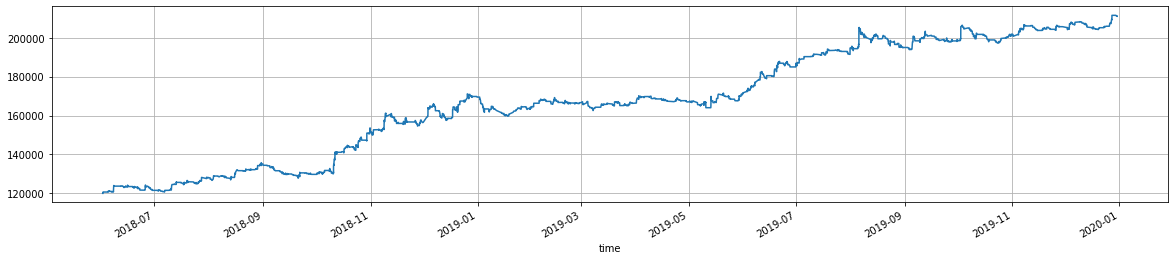

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     421
 GC     888
 NQ    1642
 YM     518
 Name: action, dtype: int64,
 3469)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.021845
 GC    2.155340
 NQ    3.985437
 YM    1.257282
 Name: action, dtype: float64,
 8.419902912621358)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     884.10
GC    2148.96
NQ    3448.20
YM    1087.80
Name: commission, dtype: float64

In [16]:
df.commission.sum()

7569.060000000002

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,31.85,476.96,-266.01,1.79,31.18,444.0
NQ,0.41,41.18,450.24,-247.97,1.82,38.30,821.0
YM,0.43,114.74,755.98,-373.83,2.02,111.99,259.0
ES,0.40,63.60,945.50,-524.34,1.80,63.60,210.0
total,0.41,52.49,563.13,-304.95,1.85,50.96,1734.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.023997,0.152328,0.388379,0.671888
GC,0.023997,1.000000,0.055282,0.075441,0.417852
NQ,0.152328,0.055282,1.000000,0.207641,0.605936
YM,0.388379,0.075441,0.207641,1.000000,0.707996
total,0.671888,0.417852,0.605936,0.707996,1.000000


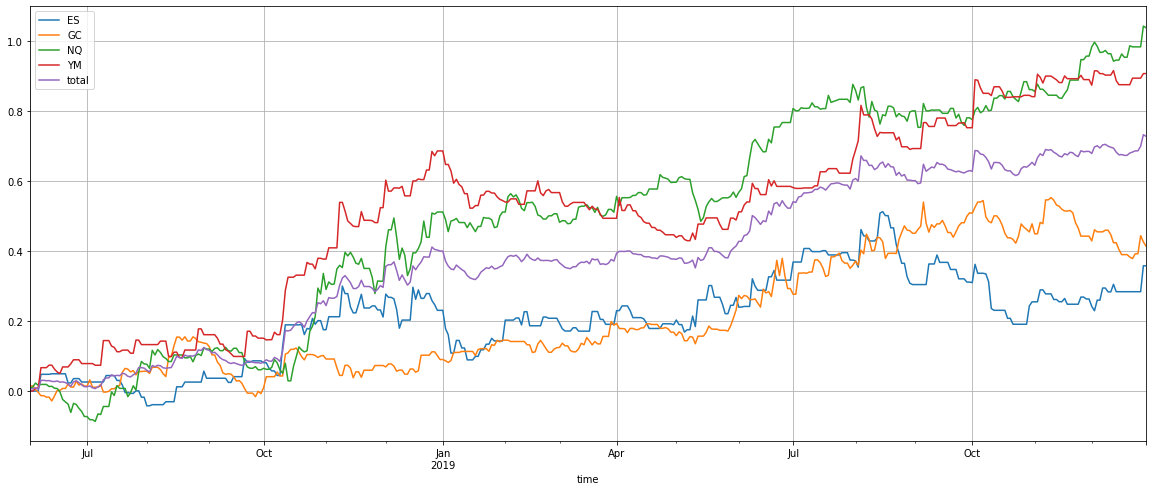

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

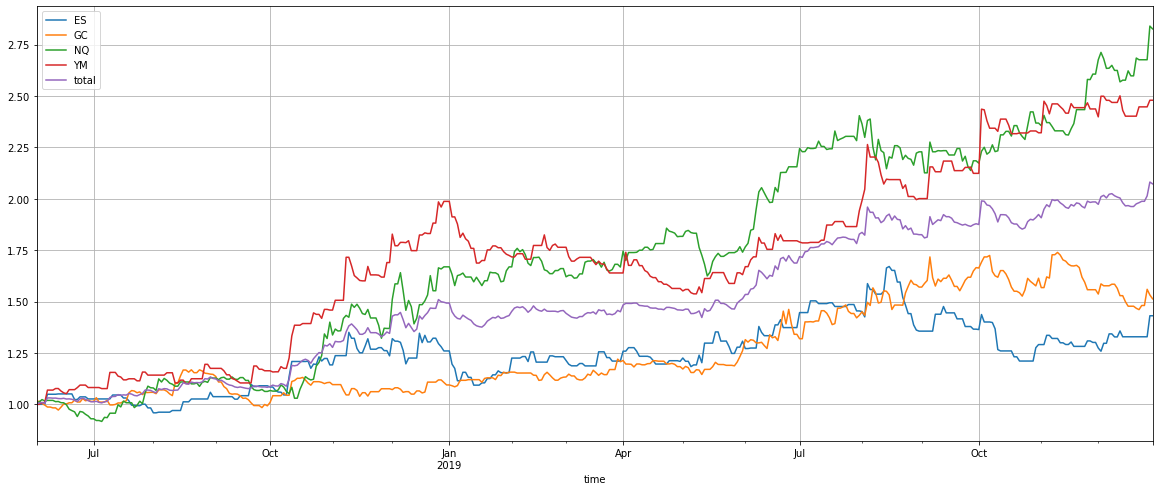

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.244974,0.288432,0.887939,0.742550,0.561647
Cumulative returns,0.430802,0.513358,1.826301,1.479240,1.072490
Annual volatility,0.329976,0.265631,0.328061,0.322753,0.190600
Sharpe ratio,0.825202,1.085387,2.101025,1.877240,2.434103
Calmar ratio,0.889695,1.801614,5.848096,3.280134,6.323943
Stability,0.625761,0.856107,0.946603,0.855689,0.951568
Max drawdown,-0.275346,-0.160096,-0.151834,-0.226378,-0.088813
Omega ratio,1.231616,1.245686,1.516966,1.660312,1.637307
Sortino ratio,1.526308,1.916303,3.804488,4.555275,5.304330
Skew,1.687779,1.084953,0.839830,2.963476,2.049684


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.62,1.43,-7.03,8.17,1.25
2018-07-31,-4.25,4.34,16.25,5.58,5.45
2018-08-31,5.57,8.24,4.35,2.87,5.45
2018-09-30,5.10,-13.34,-5.77,-0.99,-3.84
2018-10-31,9.32,11.51,31.73,25.37,19.57
2018-11-30,3.69,-2.81,-2.20,15.85,3.91
2018-12-31,1.93,1.72,21.89,17.61,10.96
2019-01-31,-8.39,5.70,-0.01,-13.23,-4.07
2019-02-28,6.72,-2.14,-0.49,2.30,1.72


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        43.0
GC        51.0
NQ       183.0
YM       148.0
total    107.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 17:24:30,YM,SELL,26173.00,4830.8
2019-10-02 20:43:00,YM,BUY,26059.00,4410.8
2018-11-09 09:34:30,ES,SELL,2793.50,4095.8
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2019-10-10 22:34:00,ES,BUY,2953.50,-1291.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.043839,0.035793,0.106360,0.074901
2018-12-03,0.067777,-0.003989,0.103247,0.081860,0.062224
2018-10-11,0.064440,0.064183,0.029133,0.088107,0.061466
2019-10-02,0.053610,0.017355,0.026633,0.147027,0.061156
2019-09-05,0.000000,0.071505,0.070387,0.077053,0.054736
...,...,...,...,...,...
2019-05-10,-0.029723,-0.018656,-0.021587,-0.017947,-0.021978
2019-08-22,-0.046947,-0.000495,-0.025280,-0.020447,-0.023292
2018-12-07,-0.030140,-0.014161,-0.053700,0.000000,-0.024500
